In [1]:
# Stock price prediction using LSTM's

In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# Get stock quote
input_df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')
input_df

High        Low       Open      Close       Volume  Adj Close
Date                                                                          
2012-01-03  14.732142  14.607142  14.621428  14.686786  302220800.0  12.669562
2012-01-04  14.810000  14.617143  14.642858  14.765715  260022000.0  12.737655
2012-01-05  14.948215  14.738214  14.819643  14.929643  271269600.0  12.879071
2012-01-06  15.098214  14.972143  14.991786  15.085714  318292800.0  13.013705
2012-01-09  15.276786  15.048214  15.196428  15.061786  394024400.0  12.993064
...               ...        ...        ...        ...          ...        ...
2019-12-11  67.775002  67.125000  67.202499  67.692497   78756800.0  67.112915
2019-12-12  68.139999  66.830002  66.945000  67.864998  137310400.0  67.283928
2019-12-13  68.824997  67.732498  67.864998  68.787498  133587600.0  68.198540
2019-12-16  70.197502  69.245003  69.250000  69.964996  128186000.0  69.365952
2019-12-17  70.442497  69.699997  69.892502  70.102501  114158400.0  69.502274

[2003 rows x 6 columns]

In [3]:
input_df.shape

(2003, 6)

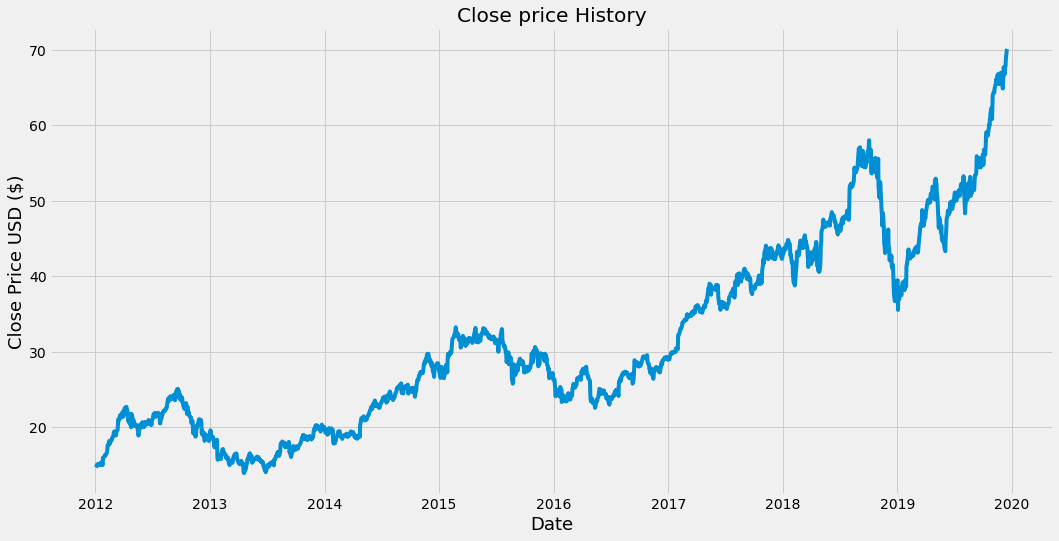

In [4]:
# Close price visualization 
plt.figure(figsize=(16, 8))
plt.title("Close price History")
plt.plot(input_df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [5]:
data = input_df.filter(['Close'])

#Convert dataframe to numpy array
dataset = data.values
#Get number of rows to train model on
training_data_len = math.ceil(len(dataset) * 0.8)

training_data_len

1603

In [6]:
dataset

array([[14.6867857 ],
       [14.76571465],
       [14.92964268],
       ...,
       [68.78749847],
       [69.96499634],
       [70.10250092]])

In [7]:
#scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01316509],
       [0.01457064],
       [0.01748985],
       ...,
       [0.97658263],
       [0.99755134],
       [1.        ]])

In [8]:
# Create training dataset
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60 : i, 0])
    y_train.append(train_data[i, 0])

In [9]:
# Convert training dataset into numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
# reshape data - LSTM requires a 3D shape
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1543, 60, 1)

In [11]:
#LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [13]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [14]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

1543/1543 [==============================] - 76s 49ms/step - loss: 7.5061e-04 - accuracy: 6.4809e-04


In [15]:
#create testing data set
#new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 60 :, :]

x_test = []
y_test = dataset[training_data_len :, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60 : i, 0])


In [16]:
#convert to numpy array
x_test = np.array(x_test)

In [17]:
#Reshape
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(400, 60, 1)

In [18]:
#Predict values
predictions = model.predict(x_test)

#unscale the predictions. y_test aren't scaled
predictions = scaler.inverse_transform(predictions)

In [19]:
#Evaluation using rmse
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
rmse

0.273178071975708

c:\users\ammuuu\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


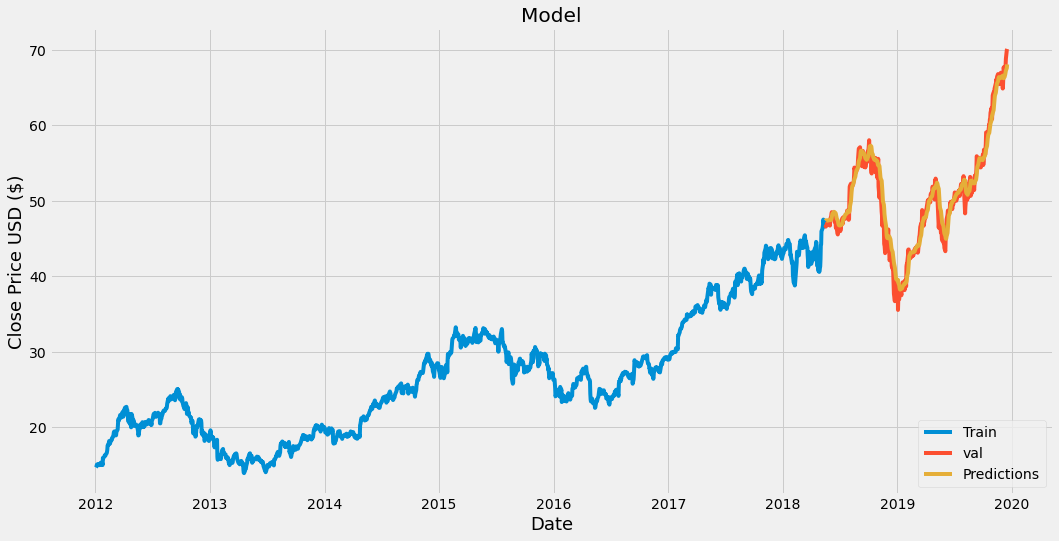

In [20]:
#Plot data
train = data[: training_data_len]
valid = data[training_data_len : ]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'val', 'Predictions'], loc='lower right')
plt.show()

In [21]:
#Predict for a specific date (predict for 2019-12-18)
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')

new_df = apple_quote.filter(['Close'])
#Get last 60 day closing prices values and convert the dataframe to array
last_60_days = new_df[ - 60 : ].values

#scale data
last_60_days_scaled = scaler.transform(last_60_days)

X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)
print(predicted_price)

[[68.56239]]


In [39]:
#Actual value for 2019-12-18
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2019-12-18', end='2019-12-18')
actual_value = apple_quote2.filter(['Close']).values[1]
print(actual_value)

[69.93499756]


In [40]:
rmse = np.sqrt(np.mean(predicted_price - actual_value) ** 2)
rmse

1.3726043701171875